In [92]:
import pandas as pd
import json
import os
import pylab as pl
import geopandas as gp
import glob
import zipfile
from sklearn.cluster import KMeans
from matplotlib import cm
from descartes import PolygonPatch
import scipy.cluster as scp
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster as scp
import pandas as pd
from pandas.io.common import ZipFile
import pylab as pl
import zipfile
from geopandas import GeoDataFrame

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Step 1: Find the number of businesses in 2010 and 2000.

In [5]:
# Getting the business data for 2000 and 2010

!wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp00totals.zip
    
!wget ftp://ftp.census.gov/econ2010/CBP_CSV/zbp10totals.zip

--2016-12-17 09:30:49--  ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp00totals.zip
           => “zbp00totals.zip”
Resolving ftp.census.gov... 148.129.75.35, 2610:20:2010:a09:1000:0:9481:4b23
Connecting to ftp.census.gov|148.129.75.35|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /Econ2001_And_Earlier/CBP_CSV ... done.
==> SIZE zbp00totals.zip ... 628434
==> PASV ... done.    ==> RETR zbp00totals.zip ... done.
Length: 628434 (614K) (unauthoritative)

100%[======================================>] 628,434      535K/s   in 1.1s    

2016-12-17 09:30:51 (535 KB/s) - “zbp00totals.zip” saved [628434]

--2016-12-17 09:30:51--  ftp://ftp.census.gov/econ2010/CBP_CSV/zbp10totals.zip
           => “zbp10totals.zip”
Resolving ftp.census.gov... 148.129.75.35, 2610:20:2010:a09:1000:0:9481:4b23
Connecting to ftp.census.gov|148.129.75.35|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... don

In [7]:
!unzip zbp00totals.zip

Archive:  zbp00totals.zip
  inflating: zbp00totals.txt         


In [8]:
os.system("mv zbp00totals.txt " + os.getenv("PUIDATA"))

0

In [9]:
!unzip zbp10totals.zip

Archive:  zbp10totals.zip
  inflating: zbp10totals.txt         


In [10]:
os.system("mv zbp10totals.txt " + os.getenv("PUIDATA"))

0

In [11]:
bus00 = pd.read_csv(os.getenv('PUIDATA') + '/' + 'zbp00totals.txt')
bus00.head()

ZIP            NAME EMPFLAG   EMP    QP1      AP  EST
0   501  HOLTSVILLE, NY       A     0      0       0    1
1  1001      AGAWAM, MA     NaN  8042  59833  259661  493
2  1002     AMHERST, MA     NaN  6547  36719  169658  563
3  1003     AMHERST, MA     NaN    82    308    2482   13
4  1004     AMHERST, MA     NaN   717   2049    5826   48

In [22]:
bus00 = bus00[['ZIP', 'EST']]
bus00.head()

ZIP  EST
0   501    1
1  1001  493
2  1002  563
3  1003   13
4  1004   48

In [12]:
bus10 = pd.read_csv(os.getenv('PUIDATA') + '/' + 'zbp10totals.txt')
bus10.head()

zip            name empflag emp_nf    emp qp1_nf    qp1 ap_nf      ap  \
0   501  HOLTSVILLE, NY       A      D      0      D      0     D       0   
1  1001      AGAWAM, MA     NaN      G   9185      G  70693     G  314508   
2  1002     AMHERST, MA     NaN      G  15633      G  82069     G  351589   
3  1003     AMHERST, MA     NaN      G    168      H   1297     H    5761   
4  1004     AMHERST, MA     NaN      H    189      H   1710     H    7241   

   est        city stabbr   cty_name  
0    2  HOLTSVILLE     NY    SUFFOLK  
1  448      AGAWAM     MA    HAMPDEN  
2  570     AMHERST     MA  HAMPSHIRE  
3   16     AMHERST     MA  HAMPSHIRE  
4   21     AMHERST     MA  HAMPSHIRE

In [24]:
bus10.rename(columns = {"zip": "ZIP", "est": "EST"}, inplace = True)
bus10 = bus10[['ZIP', 'EST']]
bus10.head()

ZIP  EST
0   501    2
1  1001  448
2  1002  570
3  1003   16
4  1004   21

### The above tables provide the number of businesses (est, for establishments) by zip code. 

In [25]:
bus00.sum(axis = 0)

ZIP    1972779752
EST       7070048
dtype: int64

In [26]:
bus10.sum(axis = 0)

ZIP    1945123164
EST       7396628
dtype: int64

### The above summaries provide the total number of businesses in 2000 and 2010, respectively. There were 7,070,048 businesses in 2000 and 7,396,628 in 2010. 

## Come back later to show differences?

## Step 2: Gather a zipcode shapefile and merge the number of businesses with the zipcode shapfile

In [29]:
!curl -O https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/HW11_fb55/nyc-zip-code-tabulation-areas-polygons.geojson

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  591k  100  591k    0     0   597k      0 --:--:-- --:--:-- --:--:-- 2348k


In [30]:
os.system("mv nyc-zip-code-tabulation-areas-polygons.geojson " + os.getenv("PUIDATA"))

0

In [58]:
zip_file = os.getenv('PUIDATA') + '/nyc-zip-code-tabulation-areas-polygons.geojson'
zip_file

'/home/cusp/lag552/PUIdata/nyc-zip-code-tabulation-areas-polygons.geojson'

In [59]:
zip_shape = gp.read_file(zip_file)

In [60]:
zip_shape = zip_shape[pd.notnull(zip_shape['postalCode'])]
zip_shape = zip_shape[['Shape_Area', 'borough', 'geometry', 'postalCode']]
zip_shape.rename(columns = {"postalCode": "ZIP"}, inplace = True)
zip_shape.head()

Shape_Area borough                                           geometry  \
0  2.016328e+07  Queens  POLYGON ((-73.86942457284175 40.74915687096787...   
1  2.260653e+07  Queens  POLYGON ((-73.71068374074007 40.75004039450917...   
2  6.269333e+06  Queens  POLYGON ((-73.70098278625547 40.73889569923034...   
3  4.941836e+07  Queens  POLYGON ((-73.72270447144122 40.75373371438336...   
4  6.938587e+07  Queens  POLYGON ((-73.81088634744755 40.72717187575918...   

     ZIP  
0  11372  
1  11004  
2  11040  
3  11426  
4  11365

In [61]:
zip_shape.dtypes

Shape_Area    float64
borough        object
geometry       object
ZIP            object
dtype: object

In [62]:
zip_shape['ZIP'] = pd.to_numeric(zip_shape['ZIP'])
zip_shape['ZIP'].head()

0    11372
1    11004
2    11040
3    11426
4    11365
Name: ZIP, dtype: int64

In [63]:
# Merging Zip Code Shapefile with Business Data

# First adding 2000 business data to shapefile
business = pd.merge(zip_shape, bus00, how='inner', on=['ZIP'])

# Then adding 2010 business data to shapefile
business = pd.merge(business, bus10, how='inner', on=['ZIP'])

business.head()

Shape_Area borough                                           geometry  \
0  2.016328e+07  Queens  POLYGON ((-73.86942457284175 40.74915687096787...   
1  2.260653e+07  Queens  POLYGON ((-73.71068374074007 40.75004039450917...   
2  6.269333e+06  Queens  POLYGON ((-73.70098278625547 40.73889569923034...   
3  4.941836e+07  Queens  POLYGON ((-73.72270447144122 40.75373371438336...   
4  6.938587e+07  Queens  POLYGON ((-73.81088634744755 40.72717187575918...   

     ZIP  EST_x  EST_y  
0  11372   1409   1629  
1  11004    189    229  
2  11040   1350   1494  
3  11426    213    248  
4  11365    553    643

In [64]:
business.rename(columns = {"EST_x" : "EST00", "EST_y" : "EST10"}, inplace = True)
business.head()

Shape_Area borough                                           geometry  \
0  2.016328e+07  Queens  POLYGON ((-73.86942457284175 40.74915687096787...   
1  2.260653e+07  Queens  POLYGON ((-73.71068374074007 40.75004039450917...   
2  6.269333e+06  Queens  POLYGON ((-73.70098278625547 40.73889569923034...   
3  4.941836e+07  Queens  POLYGON ((-73.72270447144122 40.75373371438336...   
4  6.938587e+07  Queens  POLYGON ((-73.81088634744755 40.72717187575918...   

     ZIP  EST00  EST10  
0  11372   1409   1629  
1  11004    189    229  
2  11040   1350   1494  
3  11426    213    248  
4  11365    553    643

In [65]:
# Later: "There are 250 zip codes with business data available in 2000 and 2010 for analysis.
len(business)

250

## Step 3: Find the density of businesses by dividing the number of businesses by the area of the zipcode and show them the density in a choroplath for 2000 and 2010 (OPTIONALLY: also show the difference in business density between 2000 and 2010 in a map, this will help you make sure you are on the right track)

# Come back to this - divide area so you can see result in maps

In [66]:
# Come back later to check the units on the Shape_Area column
# https://catalog.data.gov/dataset/zip-code-boundaries

business['Dens00'] = business['EST00'] / business['Shape_Area']
business['Dens10'] = business['EST10'] / business['Shape_Area']
business.head()

Shape_Area borough                                           geometry  \
0  2.016328e+07  Queens  POLYGON ((-73.86942457284175 40.74915687096787...   
1  2.260653e+07  Queens  POLYGON ((-73.71068374074007 40.75004039450917...   
2  6.269333e+06  Queens  POLYGON ((-73.70098278625547 40.73889569923034...   
3  4.941836e+07  Queens  POLYGON ((-73.72270447144122 40.75373371438336...   
4  6.938587e+07  Queens  POLYGON ((-73.81088634744755 40.72717187575918...   

     ZIP  EST00  EST10    Dens00    Dens10  
0  11372   1409   1629  0.000070  0.000081  
1  11004    189    229  0.000008  0.000010  
2  11040   1350   1494  0.000215  0.000238  
3  11426    213    248  0.000004  0.000005  
4  11365    553    643  0.000008  0.000009

In [69]:
# Adding Difference in Density column

business['DensDiff'] = business['Dens10'] / business['Dens00']
business.head()

Shape_Area borough                                           geometry  \
0  2.016328e+07  Queens  POLYGON ((-73.86942457284175 40.74915687096787...   
1  2.260653e+07  Queens  POLYGON ((-73.71068374074007 40.75004039450917...   
2  6.269333e+06  Queens  POLYGON ((-73.70098278625547 40.73889569923034...   
3  4.941836e+07  Queens  POLYGON ((-73.72270447144122 40.75373371438336...   
4  6.938587e+07  Queens  POLYGON ((-73.81088634744755 40.72717187575918...   

     ZIP  EST00  EST10    Dens00    Dens10  DensDiff  
0  11372   1409   1629  0.000070  0.000081  1.156139  
1  11004    189    229  0.000008  0.000010  1.211640  
2  11040   1350   1494  0.000215  0.000238  1.106667  
3  11426    213    248  0.000004  0.000005  1.164319  
4  11365    553    643  0.000008  0.000009  1.162749

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


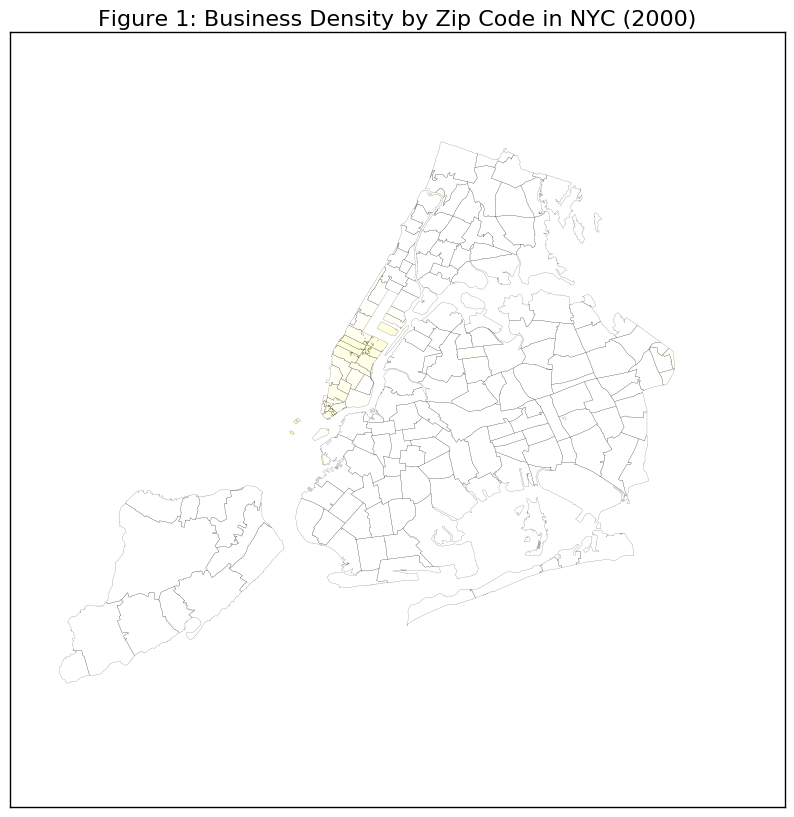

In [67]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
business.plot(column = 'Dens00', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Figure 1: Business Density by Zip Code in NYC (2000)", fontsize = 16)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


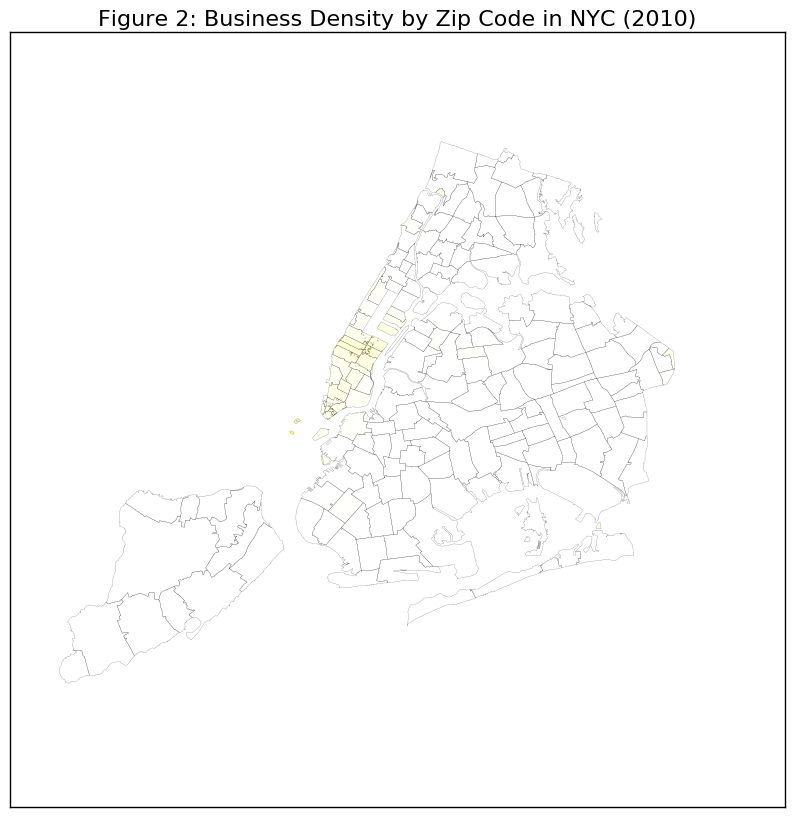

In [68]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
business.plot(column = 'Dens10', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Figure 2: Business Density by Zip Code in NYC (2010)", fontsize = 16)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


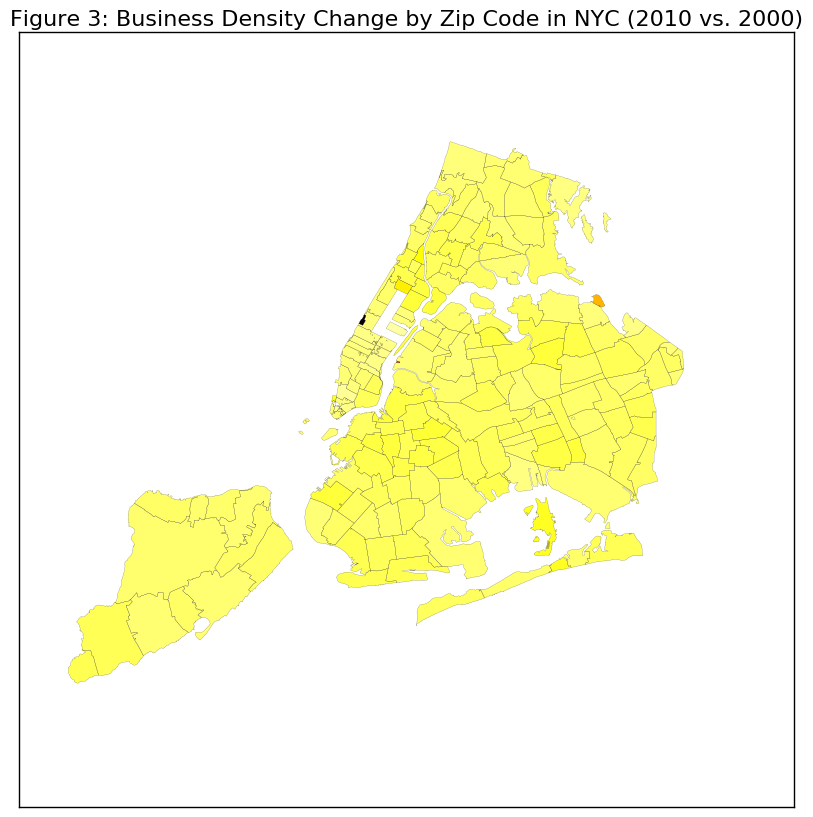

In [70]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
business.plot(column = 'DensDiff', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Figure 3: Business Density Change by Zip Code in NYC (2010 vs. 2000)", fontsize = 16)

## Step 4: Collect census data from the 2010 and 2000 census and extract the estimate (mean) age, population, and diversity of each census tract for all 5 NYC boroughs. The diversity (or lack thereof) can be measured by the fraction of white population.

In [ ]:
# http://www2.census.gov/geo/tiger/TIGER2010DP1/Tract_2010Census_DP1.zip

# https://www.census.gov/geo/maps-data/data/tiger-data.html

# COME BACK LATER AND MOVE TO PUIDATA

In [97]:
!wget http://www2.census.gov/geo/tiger/TIGER2010DP1/Tract_2010Census_DP1.zip

--2016-12-17 13:05:26--  http://www2.census.gov/geo/tiger/TIGER2010DP1/Tract_2010Census_DP1.zip
Resolving www2.census.gov... 23.217.164.116, 2600:141b:5:39e::208c, 2600:141b:5:394::208c
Connecting to www2.census.gov|23.217.164.116|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 409901240 (391M) [application/zip]
Saving to: “Tract_2010Census_DP1.zip”

100%[======================================>] 409,901,240 27.8M/s   in 12s     

2016-12-17 13:05:39 (31.4 MB/s) - “Tract_2010Census_DP1.zip” saved [409901240/409901240]



In [100]:
!unzip Tract_2010Census_DP1.zip

Archive:  Tract_2010Census_DP1.zip
  inflating: DP_TableDescriptions.xls  
  inflating: Tract_2010Census_DP1.dbf  
  inflating: Tract_2010Census_DP1.prj  
  inflating: Tract_2010Census_DP1.shp  
  inflating: Tract_2010Census_DP1.shx  


In [102]:
# COME BACK LATER and change to ct19_shape (takes a while to download)

ct10_shape = GeoDataFrame.from_file("Tract_2010Census_DP1.shp")
ct10_shape.head()

ALAND10   AWATER10  DP0010001  DP0010002  DP0010003  DP0010004  \
0  352811329.0   499970.0       1638         98         87         88   
1   16201446.0  8339342.0       4583        456        387        363   
2   14630162.0   380622.0       2055        110        137        128   
3  127200997.0   112809.0       1727        101        112        106   
4  101697268.0  1101261.0       2099        137        160        166   

   DP0010005  DP0010006  DP0010007  DP0010008  \
0        115         76         96         78   
1        348        326        313        230   
2        150        108        112        104   
3        120         88        103         78   
4        149        129        122        123   

                         ...                          DP0220002  DP0230001  \
0                        ...                                355       2.36   
1                        ...                               2387       2.56   
2                        ...                                798       2.29   
3                        ...                                663       2.46   
4                        ...                                804       2.54   

   DP0230002      GEOID10   INTPTLAT10    INTPTLON10         NAMELSAD10  \
0       2.75  01005950300  +31.7908933  -085.5670514  Census Tract 9503   
1       2.57  01005950900  +31.8467221  -085.1462332  Census Tract 9509   
2       2.27  01005950800  +31.9206930  -085.1760317  Census Tract 9508   
3       2.42  01005950700  +31.9440855  -085.2620842  Census Tract 9507   
4       2.53  01005950600  +31.8783526  -085.2729215  Census Tract 9506   

   Shape_Area  Shape_Leng                                           geometry  
0    0.033648    1.164633  POLYGON ((-85.52743699999996 31.86650300000008...  
1    0.002338    0.280687  POLYGON ((-85.16412199999996 31.83059499999996...  
2    0.001431    0.173100  POLYGON ((-85.14871799999997 31.909335, -85.14...  
3    0.012143    0.622975  POLYGON ((-85.14578399999999 31.89149100000009...  
4    0.009798    0.556037  POLYGON ((-85.14572299999998 31.89010600000006...  

[5 rows x 195 columns]

In [110]:
# rerun later (it's fine)
ct10_shape = ct10_shape[['DP0010001', 'DP0020001', 'DP0080003', 'DP0080001', 'GEOID10', 'Shape_Area', 'geometry']]
ct_shape.rename(columns = {'DP0010001' : 'TotPop', 'DP0020001' : 'MedAge', 'DP0080003' : 'White', 'DP0080001' : 'TotRace'}, inplace = True)
ct_shape.head()

In [105]:
# Number of CTs in NYC
len(ct_shape)

74002

In [115]:
ct10_shape['PercWhite'] = (ct10_shape['White'] / ct10_shape['TotRace']) * 100
ct10_shape.head()

TotPop  MedAge  White  TotRace      GEOID10  Shape_Area  \
0    1638    44.8    718     1638  01005950300    0.033648   
1    4583    32.0   1842     4583  01005950900    0.002338   
2    2055    42.6   1150     2055  01005950800    0.001431   
3    1727    43.8    764     1727  01005950700    0.012143   
4    2099    37.2   1148     2099  01005950600    0.009798   

                                            geometry  PercWhite  
0  POLYGON ((-85.52743699999996 31.86650300000008...  43.833944  
1  POLYGON ((-85.16412199999996 31.83059499999996...  40.192014  
2  POLYGON ((-85.14871799999997 31.909335, -85.14...  55.961071  
3  POLYGON ((-85.14578399999999 31.89149100000009...  44.238564  
4  POLYGON ((-85.14572299999998 31.89010600000006...  54.692711

In [126]:
ct_geom = ct10_shape[['GEOID10', 'geometry']]
ct_geom.head()

GEOID10                                           geometry
0  01005950300  POLYGON ((-85.52743699999996 31.86650300000008...
1  01005950900  POLYGON ((-85.16412199999996 31.83059499999996...
2  01005950800  POLYGON ((-85.14871799999997 31.909335, -85.14...
3  01005950700  POLYGON ((-85.14578399999999 31.89149100000009...
4  01005950600  POLYGON ((-85.14572299999998 31.89010600000006...

In [113]:
!wget http://cosmo.nyu.edu/~fb55/PUI2016/data/census00_final.json

--2016-12-17 14:02:22--  http://cosmo.nyu.edu/~fb55/PUI2016/data/census00_final.json
Resolving cosmo.nyu.edu... 128.122.53.240
Connecting to cosmo.nyu.edu|128.122.53.240|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 373714 (365K) [application/json]
Saving to: “census00_final.json”

100%[======================================>] 373,714     --.-K/s   in 0.004s  

2016-12-17 14:02:22 (82.3 MB/s) - “census00_final.json” saved [373714/373714]



## 5) Collect the income data by census tract from the income from American Fact Finder for the years 2010 and 2000 at the census tract level.

## 6) Merge the datasets for each year and show a the tables containing the relevant data: the features and whatever else you need to identify and plot the data.

In [ ]:
features00 = pd.merge(zip_shape, bus00, how='inner', on=['ZIP'])

## COME BACK LATER and figure out how to get the demographic stuff for 2000,
## And income for both.
## Used her link below

In [114]:
data00 = pd.read_json('census00_final.json')
data00.head()

age  diversity                geo_id  income  population
0      0.0        NaN  1400000US36047054300       0           0
1      0.0        NaN  1400000US36081121100       0           0
10    47.5       34.0  1400000US36029001401      50         106
100   39.3       89.2  1400000US36001001901     946        2656
1000  40.9       98.7  1400000US36029013800    2374        7663

In [124]:
# http://stackoverflow.com/questions/20970279/how-to-do-a-left-right-and-mid-of-a-string-in-a-pandas-dataframe
data00['GEOID10'] = data00['geo_id'].str[-11:] # I MIGHT HAVE SCREWED THIS UP LATER ON, NEED TO RERUN
data00.drop('geo_id', axis=1, inplace=True)
data00.head()

age  diversity  income  population      GEOID10
0      0.0        NaN       0           0  36047054300
1      0.0        NaN       0           0  36081121100
10    47.5       34.0      50         106  36029001401
100   39.3       89.2     946        2656  36001001901
1000  40.9       98.7    2374        7663  36029013800

In [116]:
!wget http://cosmo.nyu.edu/~fb55/PUI2016/data/census10_final.json

--2016-12-17 14:18:37--  http://cosmo.nyu.edu/~fb55/PUI2016/data/census10_final.json
Resolving cosmo.nyu.edu... 128.122.53.240
Connecting to cosmo.nyu.edu|128.122.53.240|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375919 (367K) [application/json]
Saving to: “census10_final.json”

100%[======================================>] 375,919     --.-K/s   in 0.004s  

2016-12-17 14:18:37 (83.5 MB/s) - “census10_final.json” saved [375919/375919]



In [118]:
data10 = pd.read_json('census10_final.json')
data10.head()

age  diversity                geo_id  income  population
0      0.0        NaN  1400000US36081038301       0           0
1     38.0       50.0  1400000US36005002400       0           4
10    16.4       98.7  1400000US36047053700     670        3575
100   33.5       82.4  1400000US36001013300    2100        4427
1000  44.5       97.4  1400000US36029014803    2350        6028

In [125]:
data10['GEOID10'] = data10['geo_id'].str[-11:]
data10.drop('geo_id', axis=1, inplace=True)
data10.head()

age  diversity  income  population      GEOID10
0      0.0        NaN       0           0  36081038301
1     38.0       50.0       0           4  36005002400
10    16.4       98.7     670        3575  36047053700
100   33.5       82.4    2100        4427  36001013300
1000  44.5       97.4    2350        6028  36029014803

## 7) Merge the df with the census tracts shapefile (see DATA and HINTS files) and display each of your features as a choropleth for both 2010 and 2000, and show the difference in the features as a third choroplath.

In [119]:
!wget http://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nycb2010_16d.zip

--2016-12-17 14:54:01--  http://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nycb2010_16d.zip
Resolving www1.nyc.gov... 23.217.171.105, 2600:141b:5:385::1500, 2600:141b:5:396::1500
Connecting to www1.nyc.gov|23.217.171.105|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5751535 (5.5M) [application/zip]
Saving to: “nycb2010_16d.zip”

100%[======================================>] 5,751,535   32.2M/s   in 0.2s    

2016-12-17 14:54:01 (32.2 MB/s) - “nycb2010_16d.zip” saved [5751535/5751535]



In [120]:
!unzip nycb2010_16d.zip

Archive:  nycb2010_16d.zip
  inflating: nycb2010_16d/nycb2010.shp  
  inflating: nycb2010_16d/nycb2010.dbf  
  inflating: nycb2010_16d/nycb2010.shx  
  inflating: nycb2010_16d/nycb2010.prj  
  inflating: nycb2010_16d/nycb2010.shp.xml  


In [143]:
ct_shapefile = GeoDataFrame.from_file("nycb2010_16d/nycb2010.shp")
ct_shapefile.head()

BCTCB2010 BoroCode       BoroName CB2010  CT2010     Shape_Area  \
0  50009001000        5  Staten Island   1000  000900  244589.603884   
1  50020011000        5  Staten Island   1000  002001  111006.286826   
2  50027001000        5  Staten Island   1000  002700  150406.766022   
3  50040001000        5  Staten Island   1000  004000  141296.561149   
4  50064001000        5  Staten Island   1000  006400  200784.983607   

    Shape_Leng                                           geometry  
0  2508.948115  POLYGON ((962269.1260375977 173705.5001831055,...  
1  1345.886422  POLYGON ((964642.2676391602 161835.2651977539,...  
2  1703.381172  POLYGON ((963363.1168212891 167356.3336181641,...  
3  1511.173743  POLYGON ((960069.9965820312 161953.6936035156,...  
4  1978.243852  POLYGON ((963023.891784668 158246.7521972656, ...

In [ ]:
# Maybe delete above shapefile - don't need it anymore

In [153]:
features00 = pd.merge(ct_geom, data00, how='inner', on=['GEOID10'])
features00.head()

GEOID10                                           geometry   age  \
0  36099951000  POLYGON ((-76.72290699999996 42.54608200000001...  41.5   
1  36099950700  POLYGON ((-76.809618 42.81351100000001, -76.81...  39.3   
2  36099950500  POLYGON ((-76.86224399999992 42.90882700000003...  40.2   
3  36099950100  POLYGON ((-76.76980099999997 42.94902200000007...  37.7   
4  36099950900  POLYGON ((-76.86346700000001 42.67961200000013...  37.3   

   diversity  income  population  
0       98.2     682        2227  
1       98.1    1107        3643  
2       98.0    1067        3950  
3       97.4     702        2261  
4       89.1    1140        4233

In [154]:
features00['GEOID9'] = features00['GEOID10'].str[-9:]
features00.drop('GEOID10', axis=1, inplace=True)
features00['county'] = features00['GEOID9'].str[:3]
features00.head()

geometry   age  diversity  income  \
0  POLYGON ((-76.72290699999996 42.54608200000001...  41.5       98.2     682   
1  POLYGON ((-76.809618 42.81351100000001, -76.81...  39.3       98.1    1107   
2  POLYGON ((-76.86224399999992 42.90882700000003...  40.2       98.0    1067   
3  POLYGON ((-76.76980099999997 42.94902200000007...  37.7       97.4     702   
4  POLYGON ((-76.86346700000001 42.67961200000013...  37.3       89.1    1140   

   population     GEOID9 county  
0        2227  099951000    099  
1        3643  099950700    099  
2        3950  099950500    099  
3        2261  099950100    099  
4        4233  099950900    099

In [157]:
features00.dtypes

geometry       object
age           float64
diversity     float64
income          int64
population      int64
GEOID9         object
county         object
dtype: object

In [163]:
# http://stackoverflow.com/questions/17071871/select-rows-from-a-dataframe-based-on-values-in-a-column-in-pandas
# Fice boroughs (counties) codes in NYC: http://library.columbia.edu/locations/dssc/data/nycounty_fips.html

features00 = features00.loc[features00['county'].isin(['005', '047', '061', '081', '085'])]
features00.head()

geometry   age  diversity  \
179  POLYGON ((-74.085082 40.63469100000003, -74.08...  32.2       53.8   
180  POLYGON ((-74.04907499999996 40.61483000000004...  41.9       81.4   
181  POLYGON ((-74.09125299999988 40.64944400000002...  30.3       29.5   
182  POLYGON ((-74.04632599999997 40.60273200000006...  26.0       74.1   
183  POLYGON ((-74.05623299999991 40.63817699999998...  31.7       41.6   

     income  population     GEOID9 county  
179     464        1672  085001700    085  
180     766        2468  085000600    085  
181    1624        4947  085000700    085  
182     377        1064  085001800    085  
183     509        1742  085000300    085

In [164]:
# Checking that only the five counties (boroughs) in NYC are included
features00['county'].unique()

array(['085', '061', '047', '081', '005'], dtype=object)

In [144]:
features10 = pd.merge(ct_geom, data10, how='inner', on=['GEOID10'])
features10.head()

GEOID10                                           geometry   age  \
4914  36049950300  POLYGON ((-75.50948699999992 43.78714200000013...  39.3   
4915  36049950400  POLYGON ((-75.30020199999996 43.691013, -75.30...  40.4   
4916  36049950600  POLYGON ((-75.31646999999998 43.69599200000005...  43.6   
4917  36049950500  POLYGON ((-75.45755999999994 43.70118400000007...  37.2   
4918  36049950700  POLYGON ((-75.53827799999999 43.42071699999997...  41.2   

      diversity  income  population  
4914       96.9    2941        7798  
4915       98.3    1078        2859  
4916       97.6     723        1818  
4917       97.9     903        2474  
4918       98.6    2060        5000

In [165]:
features10['GEOID9'] = features10['GEOID10'].str[-9:]
features10.drop('GEOID10', axis=1, inplace=True)
features10['county'] = features10['GEOID9'].str[:3]
features10.head()

geometry   age  diversity  income  \
0  POLYGON ((-76.72290699999996 42.54608200000001...  45.4       96.6     944   
1  POLYGON ((-76.809618 42.81351100000001, -76.81...  43.8       97.7    1488   
2  POLYGON ((-76.86224399999992 42.90882700000003...  43.0       96.1    1545   
3  POLYGON ((-76.76980099999997 42.94902200000007...  39.7       97.6     895   
4  POLYGON ((-76.86346700000001 42.67961200000013...  43.3       96.8    1409   

   population     GEOID9 county  
0        2154  099951000    099  
1        3929  099950700    099  
2        3917  099950500    099  
3        2452  099950100    099  
4        3861  099950900    099

In [166]:
features10 = features10.loc[features10['county'].isin(['005', '047', '061', '081', '085'])]
features10.head()

geometry   age  diversity  \
191  POLYGON ((-74.085082 40.63469100000003, -74.08...  32.5       52.3   
192  POLYGON ((-74.04907499999996 40.61483000000004...  48.7       74.8   
193  POLYGON ((-74.09125299999988 40.64944400000002...  33.9       31.0   
194  POLYGON ((-74.04632599999997 40.60273200000006...  25.5       77.7   
195  POLYGON ((-74.05623299999991 40.63817699999998...  40.3       55.7   

     income  population     GEOID9 county  
191     548        1788  085001700    085  
192    1190        2408  085000600    085  
193    2180        4915  085000700    085  
194     310         731  085001800    085  
195     884        1927  085000300    085

In [141]:
# Creating a dataframe for the differences in features from 2000 to 2010 (2010 features minus 2000 features)
features_diff = pd.merge(features00, features10, how='inner', on=['GEOID10'])
features_diff['age'] = features_diff['age_y'] - features_diff['age_x']
features_diff['diversity'] = features_diff['diversity_y'] - features_diff['diversity_x']
features_diff['income'] = features_diff['income_y'] - features_diff['income_x']
features_diff['population'] = features_diff['population_y'] - features_diff['population_x']
features_diff.rename(columns = {'geometry_x': 'geometry'}, inplace = True)
features_diff = features_diff[['GEOID10', 'geometry', 'age', 'diversity', 'income', 'population']]
features_diff.head()

GEOID10                                           geometry  age  \
0  36099951000  POLYGON ((-76.72290699999996 42.54608200000001...  3.9   
1  36099950700  POLYGON ((-76.809618 42.81351100000001, -76.81...  4.5   
2  36099950500  POLYGON ((-76.86224399999992 42.90882700000003...  2.8   
3  36099950100  POLYGON ((-76.76980099999997 42.94902200000007...  2.0   
4  36099950900  POLYGON ((-76.86346700000001 42.67961200000013...  6.0   

   diversity  income  population  
0       -1.6     262         -73  
1       -0.4     381         286  
2       -1.9     478         -33  
3        0.2     193         191  
4        7.7     269        -372

In [167]:
features_diff['GEOID9'] = features_diff['GEOID10'].str[-9:]
features_diff.drop('GEOID10', axis=1, inplace=True)
features_diff['county'] = features_diff['GEOID9'].str[:3]
features_diff.head()

geometry  age  diversity  income  \
0  POLYGON ((-76.72290699999996 42.54608200000001...  3.9       -1.6     262   
1  POLYGON ((-76.809618 42.81351100000001, -76.81...  4.5       -0.4     381   
2  POLYGON ((-76.86224399999992 42.90882700000003...  2.8       -1.9     478   
3  POLYGON ((-76.76980099999997 42.94902200000007...  2.0        0.2     193   
4  POLYGON ((-76.86346700000001 42.67961200000013...  6.0        7.7     269   

   population     GEOID9 county  
0         -73  099951000    099  
1         286  099950700    099  
2         -33  099950500    099  
3         191  099950100    099  
4        -372  099950900    099

In [168]:
features_diff = features_diff.loc[features_diff['county'].isin(['005', '047', '061', '081', '085'])]
features_diff.head()

geometry  age  diversity  \
179  POLYGON ((-74.085082 40.63469100000003, -74.08...  0.3       -1.5   
180  POLYGON ((-74.04907499999996 40.61483000000004...  6.8       -6.6   
181  POLYGON ((-74.09125299999988 40.64944400000002...  3.6        1.5   
182  POLYGON ((-74.04632599999997 40.60273200000006... -0.5        3.6   
183  POLYGON ((-74.05623299999991 40.63817699999998...  8.6       14.1   

     income  population     GEOID9 county  
179      84         116  085001700    085  
180     424         -60  085000600    085  
181     556         -32  085000700    085  
182     -67        -333  085001800    085  
183     375         185  085000300    085

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


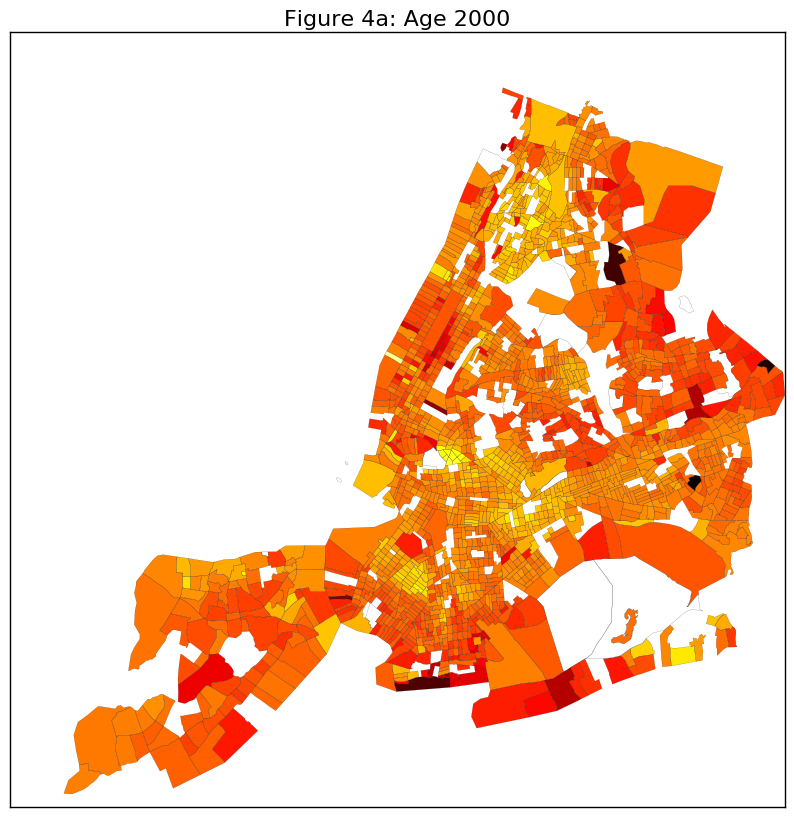

In [170]:
#http://matplotlib.org/examples/pylab_examples/subplots_demo.html

f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

features00.plot(column = 'age', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Figure 4a: Age 2000", fontsize = 16)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


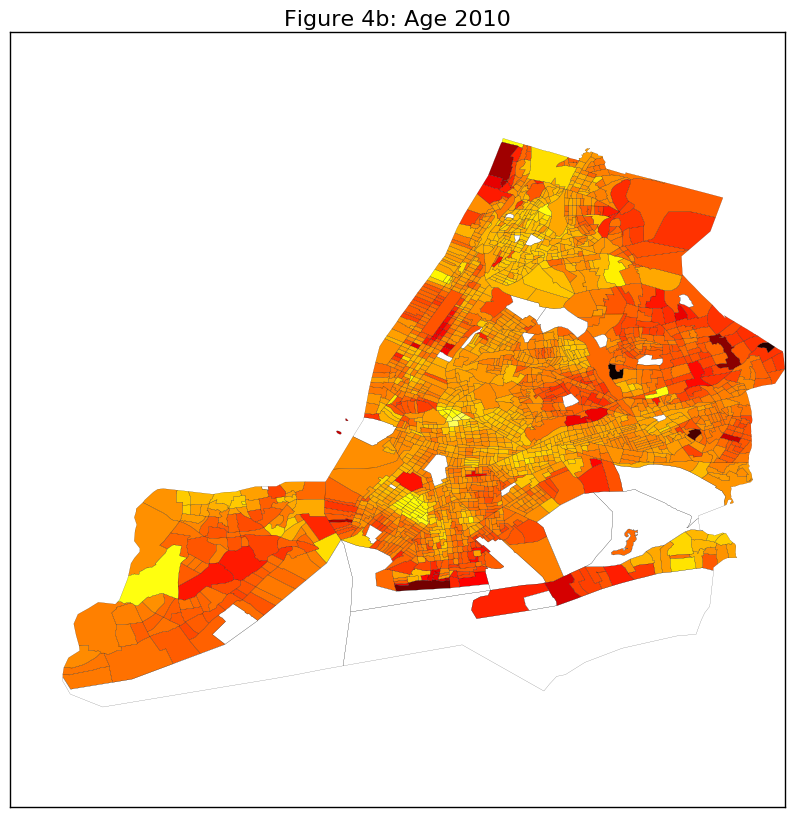

In [171]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

features10.plot(column = 'age', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Figure 4b: Age 2010", fontsize = 16)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


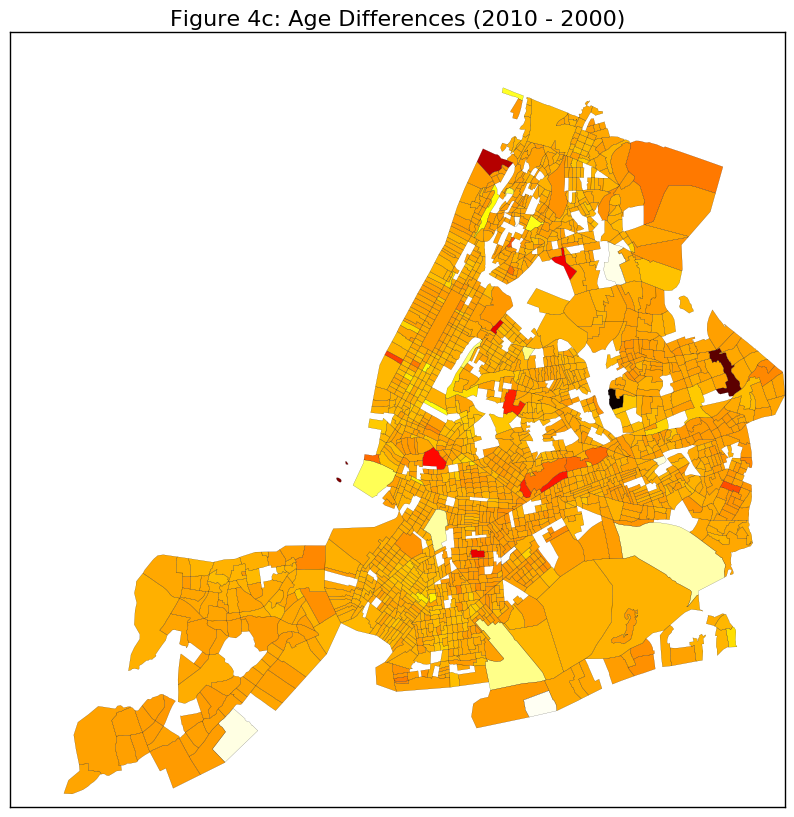

In [172]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

features_diff.plot(column = 'age', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Figure 4c: Age Differences (2010 - 2000)", fontsize = 16)

In [ ]:
# COME BACK LATER and add figure captions

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


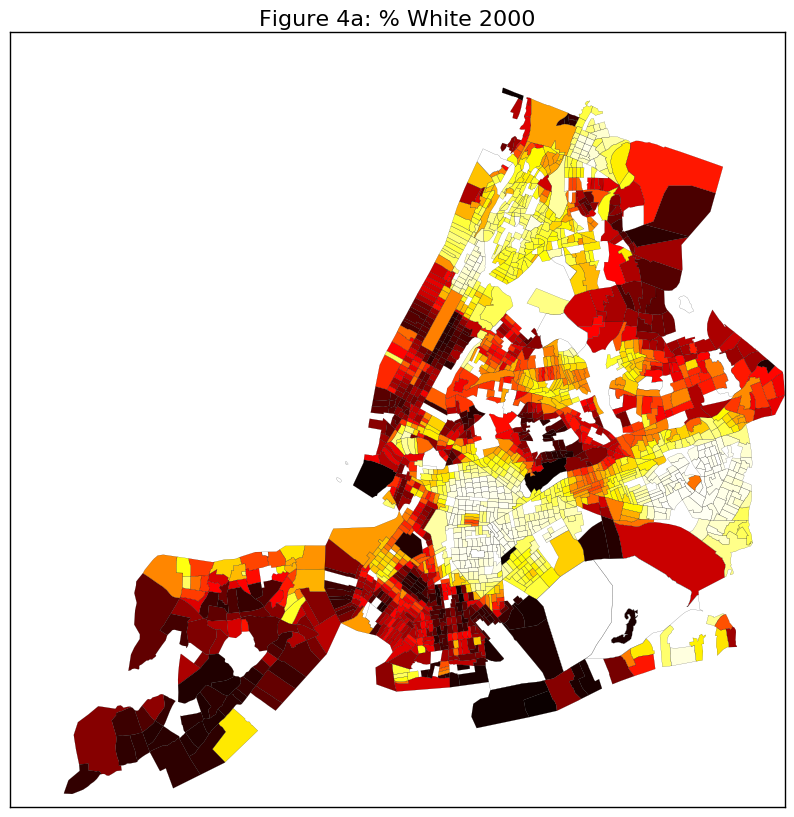

In [175]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

features00.plot(column = 'diversity', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Figure 4a: % White 2000", fontsize = 16)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


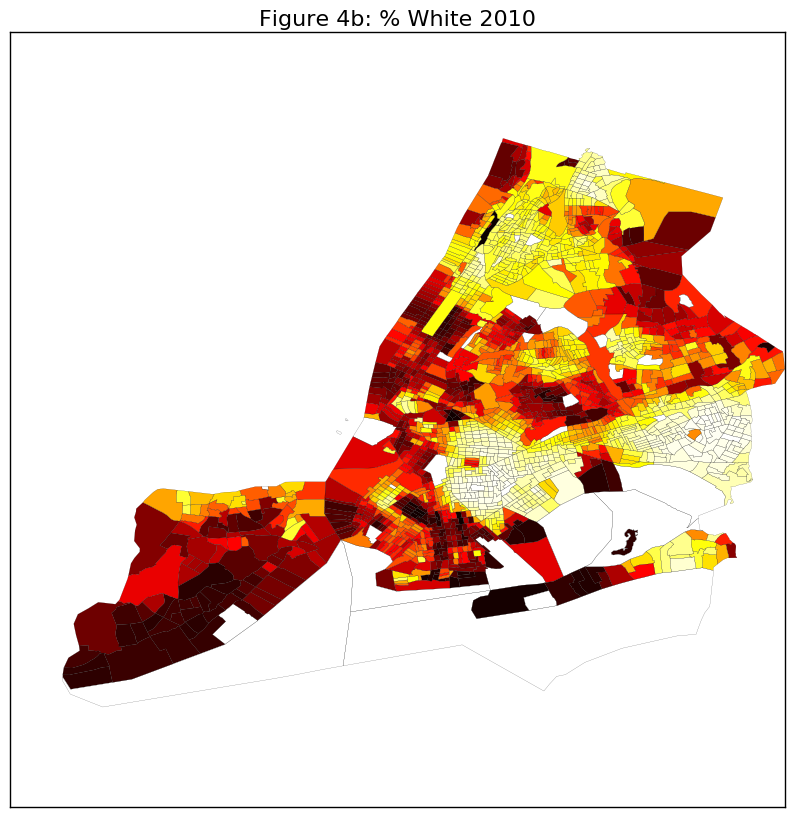

In [176]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

features10.plot(column = 'diversity', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Figure 4b: % White 2010", fontsize = 16)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


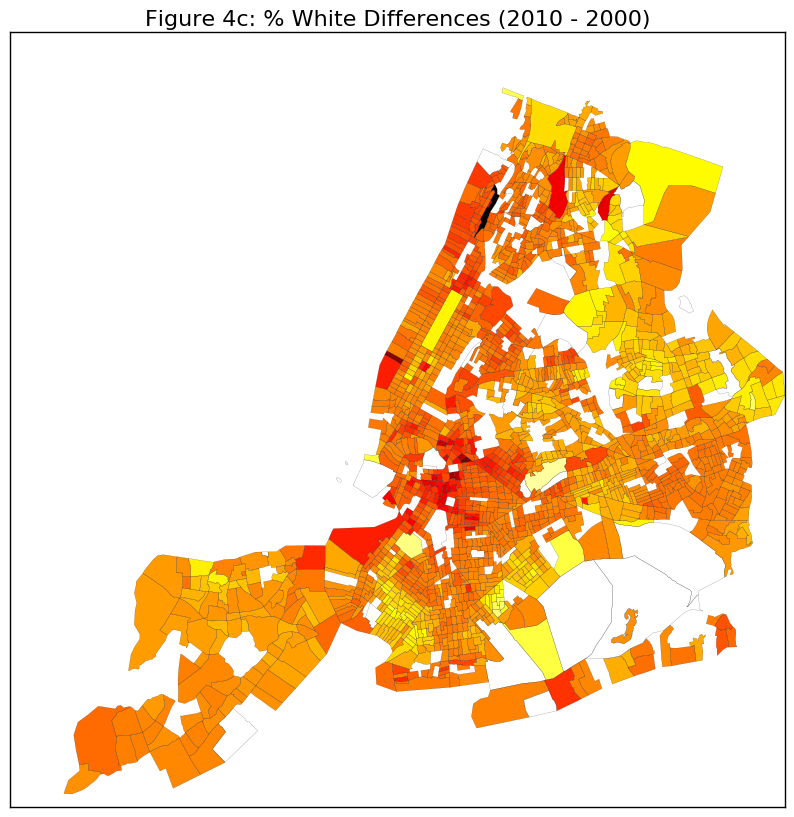

In [177]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

features_diff.plot(column = 'diversity', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Figure 4c: % White Differences (2010 - 2000)", fontsize = 16)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


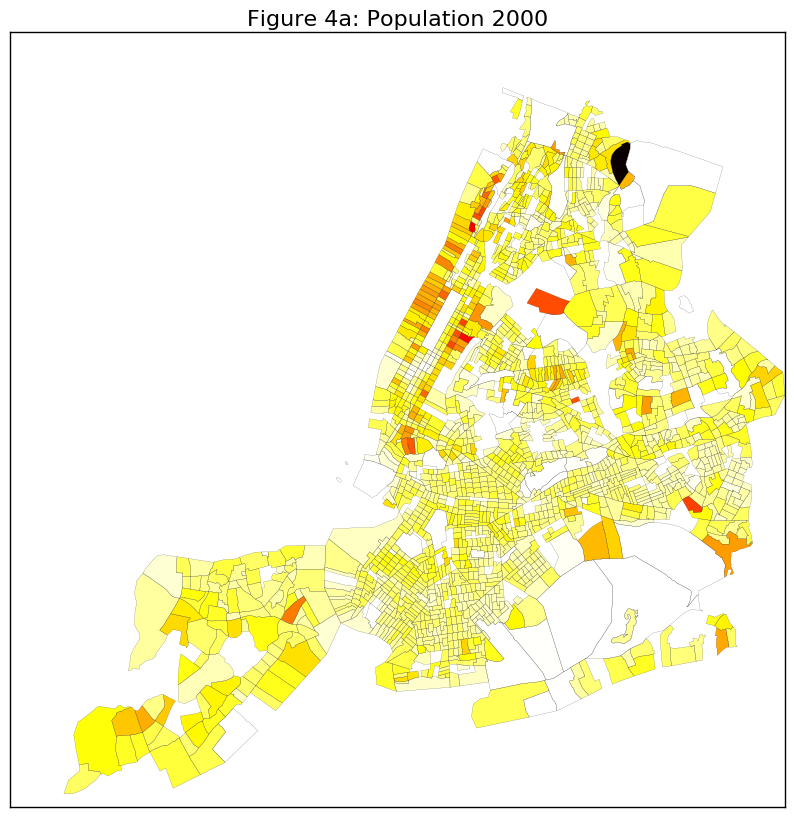

In [178]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

features00.plot(column = 'population', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Figure 4a: Population 2000", fontsize = 16)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


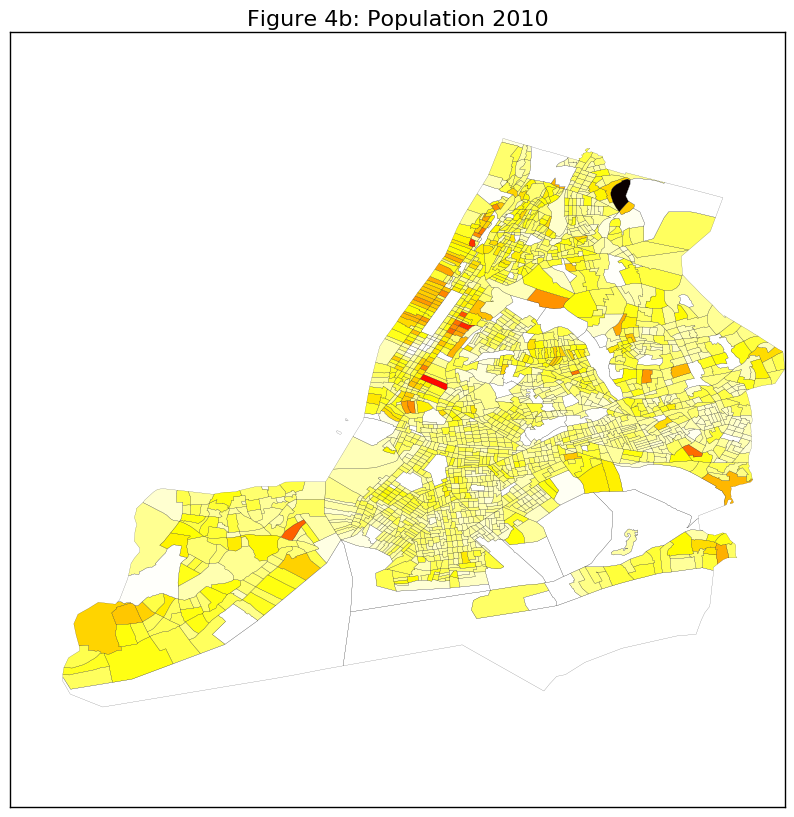

In [179]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

features10.plot(column = 'population', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Figure 4b: Population 2010", fontsize = 16)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


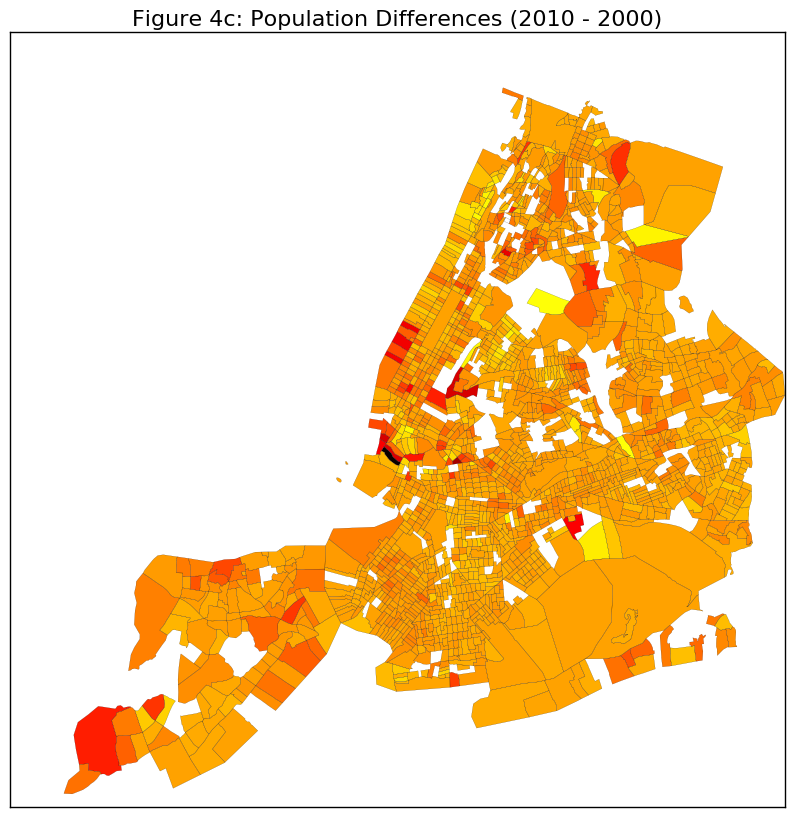

In [180]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

features_diff.plot(column = 'population', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Figure 4c: Population Differences (2010 - 2000)", fontsize = 16)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


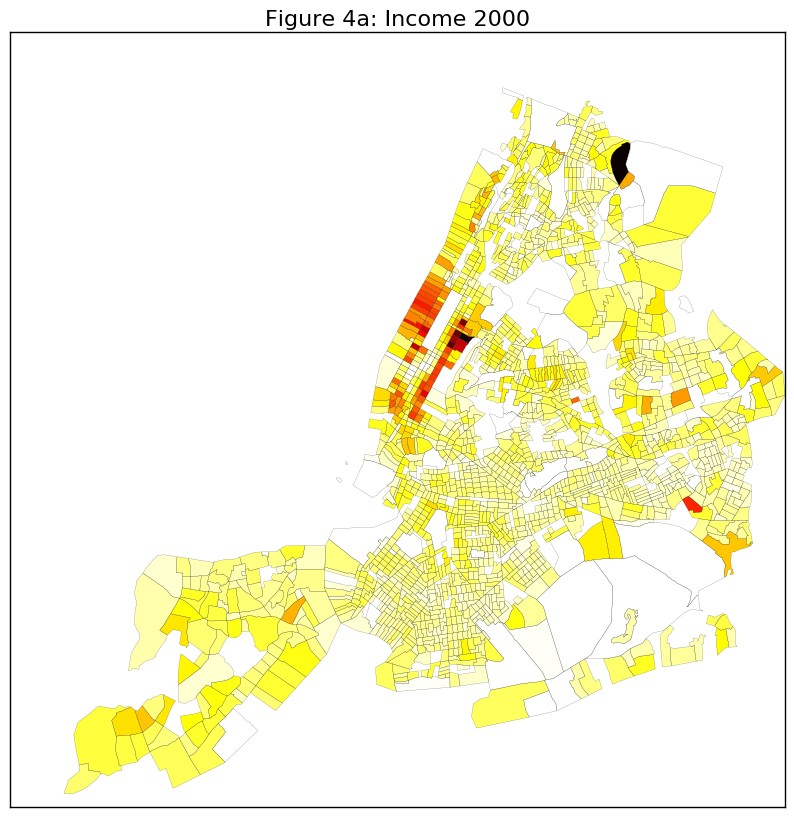

In [181]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

features00.plot(column = 'income', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Figure 4a: Income 2000", fontsize = 16)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


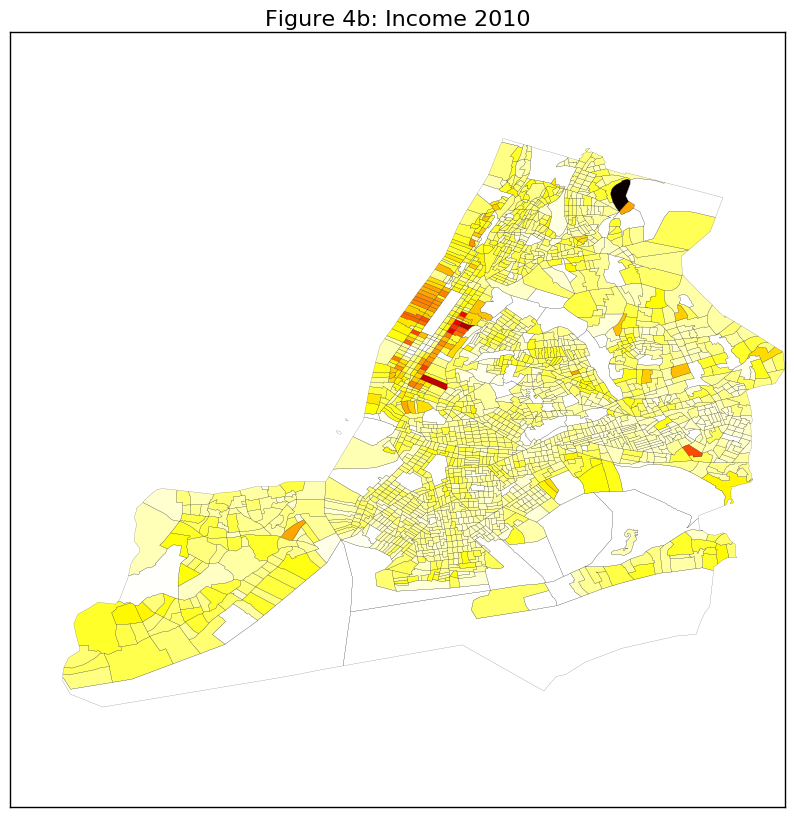

In [182]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

features10.plot(column = 'income', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Figure 4b: Income 2010", fontsize = 16)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


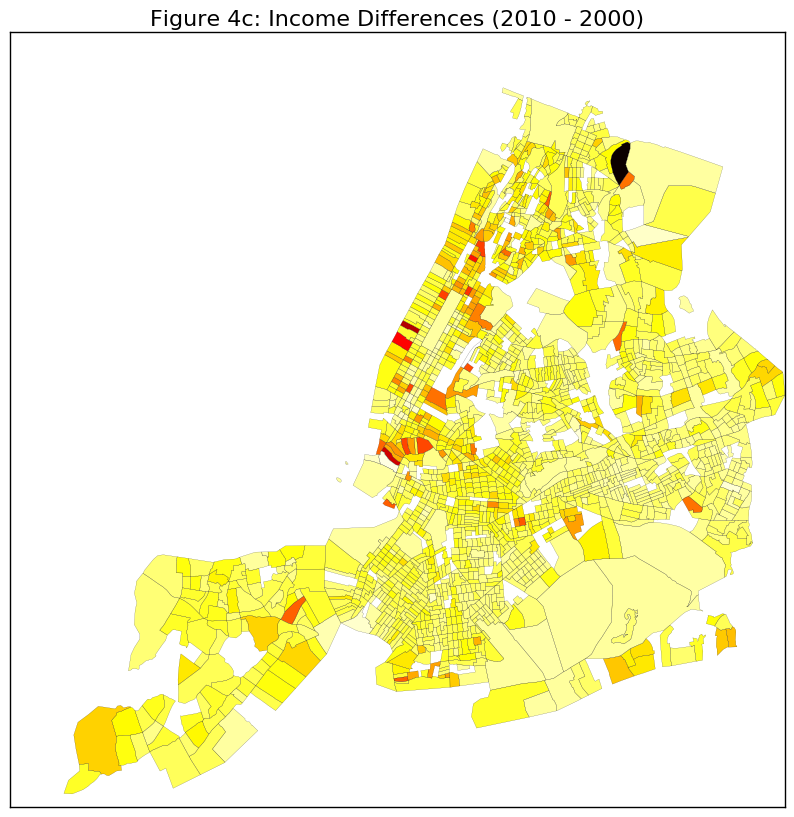

In [183]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

features_diff.plot(column = 'income', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Figure 4c: Income Differences (2010 - 2000)", fontsize = 16)

## Step 10:
### Aggregate the census four features at the zipcode level and merge the zipcode dataframe

In [281]:
# willl need a new shapefile now with geometries by zip code
# https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip
# https://data.cityofnewyork.us/Business/Zip-Code-Boundaries/i8iw-xf4u/data

!wget https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip

--2016-12-17 18:14:06--  https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip
Resolving data.cityofnewyork.us... 52.206.140.199
Connecting to data.cityofnewyork.us|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.cityofnewyork.us/api/file_data/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip [following]
--2016-12-17 18:14:06--  https://data.cityofnewyork.us/api/file_data/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip
Connecting to data.cityofnewyork.us|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1514401 (1.4M) [application/octet-stream]
Saving to: “application%2Fzip.1”

100%[======================================>] 1,514,401   1.93M/s   in 0.7s    

2016-12-17 18:14:07 (1.93 MB/s) - “application%2Fzip.1” saved [1514401/1514401]



In [285]:
zip_shapefile = GeoDataFrame.from_file("ZIP_CODE_040114.shp")
zip_shapefile = zip_shapefile[['AREA', 'POPULATION', 'ZIPCODE', 'geometry']]
zip_shapefile.rename(columns = {"ZIPCODE": "ZIP"}, inplace = True)
zip_shapefile.head()

AREA  POPULATION    ZIP  \
0  2.269930e+07     18681.0  11436   
1  2.963100e+07     62426.0  11213   
2  4.197210e+07     83866.0  11212   
3  2.369863e+07     56527.0  11225   
4  3.686880e+07     72280.0  11218   

                                            geometry  
0  POLYGON ((1038098.251871482 188138.3800067157,...  
1  POLYGON ((1001613.712964058 186926.4395172149,...  
2  POLYGON ((1011174.275535807 183696.33770971, 1...  
3  POLYGON ((995908.3654508889 183617.6128015518,...  
4  POLYGON ((991997.1134308875 176307.4958601296,...

In [208]:
# 4th Quarter 2010 file with ZIP to CT data downloaded from: https://www.huduser.gov/portal/datasets/usps_crosswalk.html

zip_ct = pd.read_excel('ZIP_TRACT_122010.xlsx')
zip_ct = zip_ct[['ZIP', 'TRACT']]
zip_ct.head()

ZIP        TRACT
0  501  36103158607
1  544  36103158607
2  601  72001956300
3  601  72001956600
4  601  72001956700

In [210]:
business.head()

Shape_Area borough                                           geometry  \
0  2.016328e+07  Queens  POLYGON ((-73.86942457284175 40.74915687096787...   
1  2.260653e+07  Queens  POLYGON ((-73.71068374074007 40.75004039450917...   
2  6.269333e+06  Queens  POLYGON ((-73.70098278625547 40.73889569923034...   
3  4.941836e+07  Queens  POLYGON ((-73.72270447144122 40.75373371438336...   
4  6.938587e+07  Queens  POLYGON ((-73.81088634744755 40.72717187575918...   

     ZIP  EST00  EST10    Dens00    Dens10  DensDiff  
0  11372   1409   1629  0.000070  0.000081  1.156139  
1  11004    189    229  0.000008  0.000010  1.211640  
2  11040   1350   1494  0.000215  0.000238  1.106667  
3  11426    213    248  0.000004  0.000005  1.164319  
4  11365    553    643  0.000008  0.000009  1.162749

In [220]:
business.dtypes

Shape_Area    float64
borough        object
geometry       object
ZIP             int64
EST00           int64
EST10           int64
Dens00        float64
Dens10        float64
DensDiff      float64
GEOID10         int64
dtype: object

In [222]:
business['GEOID10'] = business['GEOID10'].astype(str)
business.dtypes

Shape_Area    float64
borough        object
geometry       object
ZIP             int64
EST00           int64
EST10           int64
Dens00        float64
Dens10        float64
DensDiff      float64
GEOID10        object
dtype: object

In [225]:
business = pd.merge(business, zip_ct, how='inner', on=['ZIP'])
business.rename(columns = {"TRACT": "GEOID10"}, inplace = True)
business['GEOID9'] = business['GEOID10'].str[-9:]
business.drop('GEOID10', axis=1, inplace=True)
business.head()

Shape_Area borough                                           geometry  \
0  2.016328e+07  Queens  POLYGON ((-73.86942457284175 40.74915687096787...   
1  2.016328e+07  Queens  POLYGON ((-73.86942457284175 40.74915687096787...   
2  2.016328e+07  Queens  POLYGON ((-73.86942457284175 40.74915687096787...   
3  2.016328e+07  Queens  POLYGON ((-73.86942457284175 40.74915687096787...   
4  2.016328e+07  Queens  POLYGON ((-73.86942457284175 40.74915687096787...   

     ZIP  EST00  EST10   Dens00    Dens10  DensDiff     GEOID9  
0  11372   1409   1629  0.00007  0.000081  1.156139  081026500  
1  11372   1409   1629  0.00007  0.000081  1.156139  081026700  
2  11372   1409   1629  0.00007  0.000081  1.156139  081026900  
3  11372   1409   1629  0.00007  0.000081  1.156139  081027100  
4  11372   1409   1629  0.00007  0.000081  1.156139  081027300

In [252]:
zip_features00 = pd.merge(business, features00, how='inner', on=['GEOID9'])
zip_features00 = zip_features00[['ZIP', 'GEOID9', 'geometry_x', 'EST00', 'Dens00', 'age', 'diversity', 'income', 'population']]
zip_features00.head()

ZIP     GEOID9                                         geometry_x  EST00  \
0  11372  081026500  POLYGON ((-73.86942457284175 40.74915687096787...   1409   
1  11373  081026500  POLYGON ((-73.88722098467157 40.72752618766134...   1244   
2  11377  081026500  POLYGON ((-73.90202516735927 40.76741680457718...   1420   
3  11372  081026700  POLYGON ((-73.86942457284175 40.74915687096787...   1409   
4  11373  081026700  POLYGON ((-73.88722098467157 40.72752618766134...   1244   

     Dens00   age  diversity  income  population  
0  0.000070  33.3       24.3    1270        4534  
1  0.000029  33.3       24.3    1270        4534  
2  0.000020  33.3       24.3    1270        4534  
3  0.000070  32.5       30.9    1767        6415  
4  0.000029  32.5       30.9    1767        6415

In [ ]:
# ZIP codes repeat several times (since each zip code contains several CTs)
# Need to find averages for age, diversity, and income and sum for population by zip code

In [291]:
# http://stackoverflow.com/questions/34734940/in-pandas-how-to-get-average-of-several-column-values-for-each-row-in-data-fram
temp = zip_features00.groupby("ZIP")['Dens00', 'age', 'diversity', 'income'].mean()
temp = test.reset_index(drop = False)

# http://stackoverflow.com/questions/16038760/python-find-average-for-columns-with-unique-matching-value-in-nested-list
# http://stackoverflow.com/questions/34657183/adding-rows-that-have-the-same-column-value-in-a-pandas-dataframe
temp2 = zip_features00.groupby("ZIP")['population'].sum()
# http://stackoverflow.com/questions/20490274/how-to-reset-index-in-a-pandas-data-frame
temp2 = temp2.reset_index(drop = False)


zip00 = pd.merge(temp, temp2, how='inner', on=['ZIP'])
zip00.rename(columns = {"Dens00": "Dens00_ave", "age": "age_ave", "diversity": "diversity_ave", 'income' : 'income_ave', 
                        "population": "pop_ave"}, inplace = True)
zip00.head()

ZIP  Dens00_ave    age_ave  diversity_ave   income_ave  pop_ave
0  10001    0.000411  36.675000      65.791667  1135.500000    31119
1  10002    0.000087  36.594444      39.883333  1383.611111    95199
2  10003    0.000237  34.153846      78.500000  2497.692308    67371
3  10004    0.000874  31.725000      70.700000   495.000000    15500
4  10005    0.000618  28.500000      68.633333   728.666667     5176

In [300]:
zip_features10 = pd.merge(business, features10, how='inner', on=['GEOID9'])
zip_features10 = zip_features10[['ZIP', 'GEOID9', 'geometry_x', 'EST10', 'Dens10', 'age', 'diversity', 'income', 'population']]

temp = zip_features10.groupby("ZIP")['Dens10', 'age', 'diversity', 'income'].mean()
temp = test.reset_index(drop = False)

temp2 = zip_features10.groupby("ZIP")['population'].sum()
temp2 = temp2.reset_index(drop = False)

zip10 = pd.merge(temp, temp2, how='inner', on=['ZIP'])
zip10.rename(columns = {"Dens10": "Dens10_ave", "age": "age_ave", "diversity": "diversity_ave", 'income' : 'income_ave', 
                        "population": "pop_ave"}, inplace = True)
zip10.head()

index    ZIP    Dens00    age_ave  diversity_ave   income_ave  pop_ave
0      0  10001  0.000411  36.675000      65.791667  1135.500000    39546
1      1  10002  0.000087  36.594444      39.883333  1383.611111    90840
2      2  10003  0.000237  34.153846      78.500000  2497.692308    69833
3      3  10004  0.000874  31.725000      70.700000   495.000000    53320
4      4  10005  0.000618  28.500000      68.633333   728.666667    15596

In [302]:
zip_features_diff = pd.merge(business, features_diff, how='inner', on=['GEOID9'])
zip_features_diff = zip_features_diff[['ZIP', 'GEOID9', 'geometry_x', 'DensDiff', 'age', 'diversity', 'income', 'population']]

temp = zip_features_diff.groupby("ZIP")['DensDiff', 'age', 'diversity', 'income'].mean()
temp = test.reset_index(drop = False)

temp2 = zip_features_diff.groupby("ZIP")['population'].sum()
temp2 = temp2.reset_index(drop = False)

zip_diff = pd.merge(temp, temp2, how='inner', on=['ZIP'])
zip_diff.rename(columns = {"DensDiff": "DensDiff_ave", "age": "age_ave", "diversity": "diversity_ave", 'income' : 'income_ave', 
                        "population": "pop_ave"}, inplace = True)
zip_diff.head()

index    ZIP    Dens00    age_ave  diversity_ave   income_ave  pop_ave
0      0  10001  0.000411  36.675000      65.791667  1135.500000     8427
1      1  10002  0.000087  36.594444      39.883333  1383.611111    -4359
2      2  10003  0.000237  34.153846      78.500000  2497.692308     2462
3      3  10004  0.000874  31.725000      70.700000   495.000000    37820
4      4  10005  0.000618  28.500000      68.633333   728.666667    10420

In [310]:
zip_shapefile.dtypes

AREA          float64
POPULATION    float64
ZIP            object
geometry       object
dtype: object

In [311]:
zip00.dtypes

ZIP                int64
Dens00_ave       float64
age_ave          float64
diversity_ave    float64
income_ave       float64
pop_ave            int64
dtype: object

In [312]:
zip_shapefile['ZIP'] = pd.to_numeric(zip_shapefile['ZIP'])
zip_shapefile.dtypes

AREA          float64
POPULATION    float64
ZIP             int64
geometry       object
dtype: object

In [314]:
zip00_shape = pd.merge(zip00, zip_shapefile, how = 'inner', on = ['ZIP'])
zip10_shape = pd.merge(zip10, zip_shapefile, how = 'inner', on = ['ZIP'])
zip_diff_shape = pd.merge(zip_diff, zip_shapefile, how = 'inner', on = ['ZIP'])

In [318]:
zip00_shape.head()

ZIP  Dens00_ave    age_ave  diversity_ave   income_ave  pop_ave  \
0  10001    0.000411  36.675000      65.791667  1135.500000    31119   
1  10002    0.000087  36.594444      39.883333  1383.611111    95199   
2  10003    0.000237  34.153846      78.500000  2497.692308    67371   
3  10004    0.000874  31.725000      70.700000   495.000000    15500   
4  10004    0.000874  31.725000      70.700000   495.000000    15500   

           AREA  POPULATION                                           geometry  
0  1.779494e+07     22413.0  POLYGON ((981958.6472873986 213464.4530421346,...  
1  2.628013e+07     81305.0  POLYGON ((991339.8703228086 207576.7837151289,...  
2  1.553838e+07     55878.0  POLYGON ((989830.469142139 207048.1263078749, ...  
3  4.002521e+06      2187.0  POLYGON ((981197.408652395 196571.0816452205, ...  
4  1.202708e+06      2187.0  POLYGON ((972696.8446168154 193014.5477478057,...

In [319]:
zip10_shape.head()

index    ZIP    Dens00    age_ave  diversity_ave   income_ave  pop_ave  \
0      0  10001  0.000411  36.675000      65.791667  1135.500000    39546   
1      1  10002  0.000087  36.594444      39.883333  1383.611111    90840   
2      2  10003  0.000237  34.153846      78.500000  2497.692308    69833   
3      3  10004  0.000874  31.725000      70.700000   495.000000    53320   
4      3  10004  0.000874  31.725000      70.700000   495.000000    53320   

           AREA  POPULATION                                           geometry  
0  1.779494e+07     22413.0  POLYGON ((981958.6472873986 213464.4530421346,...  
1  2.628013e+07     81305.0  POLYGON ((991339.8703228086 207576.7837151289,...  
2  1.553838e+07     55878.0  POLYGON ((989830.469142139 207048.1263078749, ...  
3  4.002521e+06      2187.0  POLYGON ((981197.408652395 196571.0816452205, ...  
4  1.202708e+06      2187.0  POLYGON ((972696.8446168154 193014.5477478057,...

In [320]:
zip_diff_shape.head()

index    ZIP    Dens00    age_ave  diversity_ave   income_ave  pop_ave  \
0      0  10001  0.000411  36.675000      65.791667  1135.500000     8427   
1      1  10002  0.000087  36.594444      39.883333  1383.611111    -4359   
2      2  10003  0.000237  34.153846      78.500000  2497.692308     2462   
3      3  10004  0.000874  31.725000      70.700000   495.000000    37820   
4      3  10004  0.000874  31.725000      70.700000   495.000000    37820   

           AREA  POPULATION                                           geometry  
0  1.779494e+07     22413.0  POLYGON ((981958.6472873986 213464.4530421346,...  
1  2.628013e+07     81305.0  POLYGON ((991339.8703228086 207576.7837151289,...  
2  1.553838e+07     55878.0  POLYGON ((989830.469142139 207048.1263078749, ...  
3  4.002521e+06      2187.0  POLYGON ((981197.408652395 196571.0816452205, ...  
4  1.202708e+06      2187.0  POLYGON ((972696.8446168154 193014.5477478057,...

# MAP these all same as before - 
### figure out the subplot thing so it's cleaner?

## Cluster the zip codes on these four features (using a Eucledian distance)

In [ ]:
# Looking for NaN rows and removing them (since clustering packages cannot handle NaNs)

cleancsb = cbs[std(cbs, 1)>0]
cleannyczips = np.array(nyczips)[std(cbs, 1)>0]
badzips =  np.where(~(std(cbs, 1)>0))[0]
np.random.seed(222)

## Identify the zip codes that have changed cluster assignment (those that are now associated with a different group of zip codes) and show a choropleth of the clusters in 2010, 2000 and a choropleth of the cluster changes